# OCR - handwritten digits

## modules import

In [1]:
import numpy as np
import cv2
from skimage.feature import hog
from matplotlib import pyplot as plt
from sklearn.externals._pilutil import imresize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import easygui


## Image classification and KNN model

In [2]:

DIGIT_WIDTH = 20
DIGIT_HEIGHT = 20
IMG_HEIGHT = 28
IMG_WIDTH = 28


class KNN_MODEL():
    def __init__(self, k=3):
        self.k = k
        self.model = cv2.ml.KNearest_create()

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        retval, results, neigh_resp, dists = self.model.findNearest(
            samples, self.k)
        return results.ravel()


## pixel binning and image processing

In [3]:

def pixel_to_combined_pixels(img_array):
    hog_featuresData = []
    for img in img_array:
        fd = hog(img,
                 orientations=10,
                 pixels_per_cell=(5, 5),
                 cells_per_block=(1, 1),
                 visualize=False)
        hog_featuresData.append(fd)
    hog_features = np.array(hog_featuresData, 'float64')
    return np.float32(hog_features)


def extract_digits(contours, hierarchy):
    hierarchy = hierarchy[0]
    bounding_rectangles = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_rectangles = []

    # find the most common heirarchy level - that is where our digits's bounding boxes are
    u, indices = np.unique(hierarchy[:, -1], return_inverse=True)
    most_common_heirarchy = u[np.argmax(np.bincount(indices))]

    for r, hr in zip(bounding_rectangles, hierarchy):
        x, y, w, h = r
        # we are trying to extract ONLY the rectangles with images in it
        # we use heirarchy to extract only the boxes that are in the same global level - to avoid digits inside other digits
        # there could be a bounding box inside every 6,9,8 because of the loops in the number's appearence - we don't want that.
        if ((w*h) > 250) and (10 <= w <= 200) and (10 <= h <= 200) and hr[3] == most_common_heirarchy:
            final_bounding_rectangles.append(r)

    return final_bounding_rectangles


def user_image_processing(img_file, model):
    print('Loading %s for optical digit recognition' % img_file)
    im = cv2.imread(img_file)
    blank_image = np.zeros((im.shape[0], im.shape[1], 3), np.uint8)
    blank_image.fill(255)

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    resized_grayscale_image = cv2.resize(imgray, (500, 500))

    cv2.imshow("Greyscale Image", resized_grayscale_image)
    cv2.waitKey(0)

    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    edged = cv2.Canny(resized_grayscale_image, 30, 150)
    cv2.imshow("Canny Image", edged)
    cv2.waitKey(0)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # rectangles of bounding the digits in user image
    digits_rectangles = extract_digits(contours, hierarchy)

    for rect in digits_rectangles:
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x+w, y+h), (100, 0, 255), 6)
        im_digit = imgray[y:y+h, x:x+w]
        im_digit = (255-im_digit)
        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))

        hog_img_data = pixel_to_combined_pixels([im_digit])
        pred = model.predict(hog_img_data)
        # box overlay
        cv2.putText(im, str(int(pred[0])), (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (100, 100, 15), 6)
       # final digits
        cv2.putText(blank_image, str(
            int(pred[0])), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 3, (55, 10, 200), 6)

    cv2.imwrite("output-images/originalOverlay.png", im)
    cv2.imwrite("output-images/finalDigits.png", blank_image)
    cv2.destroyAllWindows()


def get_contour_precedence(contour, cols):
    return contour[1] * cols + contour[0]  # row-wise ordering


# this function processes a custom training image
def load_handwritten_image(img_file):
    train_data = []
    train_target = []
    start_class = 1
    im = cv2.imread(img_file)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    plt.imshow(imgray)
    kernel = np.ones((5, 5), np.uint8)

    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.erode(thresh, kernel, iterations=1)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.erode(thresh, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # rectangles of bounding the digits in user image
    digits_rectangles = extract_digits(contours, hierarchy)

    # sort rectangles accoring to x,y pos so that we can label them
    digits_rectangles.sort(
        key=lambda x: get_contour_precedence(x, im.shape[1]))

    for index, rect in enumerate(digits_rectangles):
        x, y, w, h = rect
        cv2.rectangle(im, (x, y), (x+w, y+h), (50, 100, 0), 3)
        im_digit = imgray[y:y+h, x:x+w]
        im_digit = (255-im_digit)

        im_digit = imresize(im_digit, (IMG_WIDTH, IMG_HEIGHT))
        train_data.append(im_digit)
        train_target.append(start_class % 10)

        if index > 0 and (index+1) % 10 == 0:
            start_class += 1
    cv2.imwrite("output-images/trainingBoxOverlay.png", im)

    return np.array(train_data), np.array(train_target)


## dataset preparation

(array([], dtype=float64), array([], dtype=float64))

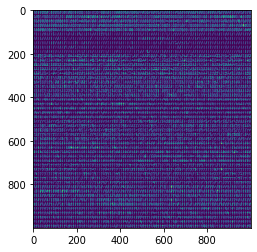

In [4]:

TRAIN_MNIST_IMG = 'digits.png'
load_handwritten_image(TRAIN_MNIST_IMG)


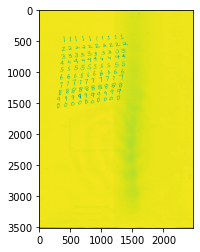

In [5]:
TRAIN_USER_IMG = 'custom_digits.jpg'
# TEST_USER_IMG = 'numbers.jpeg'
TEST_USER_IMG = easygui.fileopenbox()
# my handwritten dataset

digits, labels = load_handwritten_image(TRAIN_USER_IMG)

digits, labels = shuffle(digits, labels, random_state=256)
train_digits_data = pixel_to_combined_pixels(digits)
X_train, X_test, y_train, y_test = train_test_split(
    train_digits_data, labels, test_size=0.33, random_state=42)



## Model and calculation


Accuracy with KNN:  81.81818181818183 %

Loading C:\Users\saad9\Desktop\ocr-app-using-algorithm\ocr-handwritten\input-images\handwritten_input.jpg for optical digit recognition


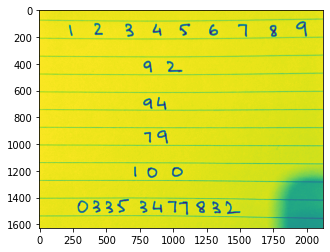

In [6]:

model = KNN_MODEL(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)

answer = accuracy_score(y_test, preds)
print('\nAccuracy with KNN: ', answer*100, '%''\n')

model = KNN_MODEL(k=5)
model.train(train_digits_data, labels)

user_image_processing(TEST_USER_IMG, model)
